In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

import pandas as pd
import gluonnlp as nlp
import numpy as np


from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel
from transformers import AdamW

from kobert.pytorch_kobert import get_pytorch_kobert_model

from kobert_hf.kobert_tokenizer import KoBERTTokenizer

from PIL import Image
import glob
import cv2

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model('C:\\Users\\cpprh/.cache\\huggingface\\transformers', '.cache') 

# KoBERT에 입력될 데이터셋 정리
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

# 모델 정의
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# Setting parameters
max_len = 64
batch_size = 8
warmup_ratio = 0.1
num_epochs = 5  
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

device = torch.device("cuda:0")

## 학습 모델 로드
PATH = './model/'
model = torch.load(PATH + 'KoBERT_test.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

#토큰화
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
#tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
tok=tokenizer.tokenize

using cached model. C:\Users\cpprh\Documents\GitHub\Emotion-Recycle-AI\.cache\kobert_v1.zip
using cached model. C:\Users\cpprh\Documents\GitHub\Emotion-Recycle-AI\.cache\kobert_news_wiki_ko_cased-1087f8699e.spiece


In [79]:
# 예측 모델 설정
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("슬픔")
            elif np.argmax(logits) == 1:
                test_eval.append("행복")
            elif np.argmax(logits) == 2:
                test_eval.append("중립")
            elif np.argmax(logits) == 3:
                test_eval.append("분노")
            elif np.argmax(logits) == 4:
                test_eval.append("놀람")
            elif np.argmax(logits) == 5:
                test_eval.append("공포")
            elif np.argmax(logits) == 6:
                test_eval.append("혐오")

        print(">> " + test_eval[0] + "의 감정이 느껴집니다.")
        
        img_path = "C\\Users\cpprh\Documents\GitHub\Emotion-Recycle-AI\img"
        images = glob.glob(f'./img/{test_eval[0]}/*.jpg')
        
        image = Image.open(images[0])
        image = np.array(image)
        GB = cv2.blur(image, (51, 51), anchor=(-1, -1), borderType=cv2.BORDER_DEFAULT)
        plt.text(image.shape[0]/4, image.shape[1]/2, predict_sentence, fontsize=10, color='white', bbox ={'facecolor':'grey', 'pad':4, 'alpha':0.4})
        plt.imshow(GB)

내용 : 좋아했어요. 나에게도 다시 기회가 오겠죠?
>> 슬픔의 감정이 느껴집니다.
1728.0 2304.0

내용 : 


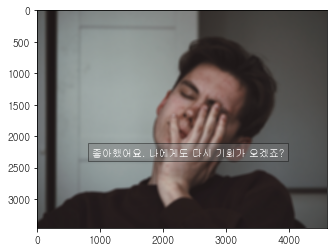

In [80]:
from matplotlib import pyplot as plt

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

while True :
    sentence = input("내용 : ")
    if sentence == "" :
        break
    predict(sentence)
    print()